# CFPB Consumer Complaints Modeling

In this notebook, the complaints made to the CFPB are analyzed to help the Financial institutions and banks reduce complaint handling cost.This is done by predicting whether a complaint will be disputed/escalated, using the historic data in hand and building a XGBoost classifier to predict the outcome. Based on the predicted outcome, the cost to the institution is calculated. 

## Importing Data and EDA

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import seaborn as sns
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn import metrics
# from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import sklearn.preprocessing as preproc

In [10]:
Complaints = pd.read_csv("shared/complaints_25Nov21.csv")
Complaints.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647


In [11]:
complaints = Complaints[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',  'Company response to consumer', 'Timely response?', 'Consumer disputed?']]
complaints.head()

,Product,Sub-product,Issue,State,Tags,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
0,Money transfers,International money transfer,Other transaction issues,NaN,NaN,Web,Closed with explanation,Yes,No
1,Bank account or service,Other bank product/service,"Account opening, closing, or management",PA,Older American,Web,Closed with explanation,Yes,No
2,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",PA,NaN,Web,Closed with monetary relief,Yes,No
3,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",VA,Servicemember,Phone,Closed with explanation,Yes,Yes
4,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",GA,NaN,Referral,Closed with explanation,Yes,No


In [12]:
complaints.isna().sum()

Product                              0
Sub-product                      43015
Issue                                0
State                             2194
Tags                            178995
Submitted via                        0
Company response to consumer         0
Timely response?                     0
Consumer disputed?                   0
dtype: int64

In [13]:
complaints['Tags'].fillna('Older American', inplace = True)

/tmp/ipykernel_141/147263926.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complaints['Tags'].fillna('Older American', inplace = True)
/tmp/ipykernel_141/147263926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints['Tags'].fillna('Older American', inplace = True)


In [14]:
complaints['Sub-product'].fillna('Other mortgage', inplace = True)

/tmp/ipykernel_141/163208651.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complaints['Sub-product'].fillna('Other mortgage', inplace = True)
/tmp/ipykernel_141/163208651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints['Sub-product'].fillna('Other mortgage', inplace = True)


In [15]:
complaints['State'].value_counts()

State
CA    37505
FL    20134
NY    15616
TX    12123
NJ     9242
      ...  
MH       11
AS        6
AA        4
MP        4
PW        3
Name: count, Length: 62, dtype: int64

In [16]:
complaints['State'].fillna('CA', inplace = True)

/tmp/ipykernel_141/2027407118.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complaints['State'].fillna('CA', inplace = True)
/tmp/ipykernel_141/2027407118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints['State'].fillna('CA', inplace = True)


In [17]:
complaints.isna().sum()

Product                         0
Sub-product                     0
Issue                           0
State                           0
Tags                            0
Submitted via                   0
Company response to consumer    0
Timely response?                0
Consumer disputed?              0
dtype: int64

In [18]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207260 entries, 0 to 207259
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Product                       207260 non-null  object
 1   Sub-product                   207260 non-null  object
 2   Issue                         207260 non-null  object
 3   State                         207260 non-null  object
 4   Tags                          207260 non-null  object
 5   Submitted via                 207260 non-null  object
 6   Company response to consumer  207260 non-null  object
 7   Timely response?              207260 non-null  object
 8   Consumer disputed?            207260 non-null  object
dtypes: object(9)
memory usage: 14.2+ MB


In [19]:
complaints_1 = pd.DataFrame()

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for column in complaints.columns:
    complaints_1[column] = label_encoder.fit_transform(complaints[column])

In [21]:
complaints_1

,Product,Sub-product,Issue,State,Tags,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
0,5,23,69,8,0,5,1,1,0
1,0,30,1,46,0,5,1,1,0
2,0,30,61,46,0,5,2,1,0
3,6,6,7,55,2,2,1,1,1
4,6,31,57,15,0,4,1,1,0
...,...,...,...,...,...,...,...,...,...
207255,4,7,85,13,0,5,1,1,0
207256,6,6,57,42,0,4,5,1,1
207257,10,28,78,38,0,5,1,1,0
207258,0,4,1,8,0,5,3,1,0


In [22]:
X = complaints_1[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',  'Company response to consumer', 'Timely response?']].values

In [23]:
y = complaints_1[['Consumer disputed?']].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

### To arrive at the desired outcome a few question need to be answered. They are:

## Question No.1: In the test set (not the entire dataset), what proportion of consumers raised a dispute?

In [25]:
unique_values, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 129853
1: 35955


In [26]:
print(35955/(129853+35955))

0.21684719675769565


## Question No.2: After performing random undersampling, what proportion of consumers in the training dataset raised a dispute?

In [27]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=123)

X_train, y_train = undersampler.fit_resample(X, y)

In [28]:
unique_values, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 44903
1: 44903


## Question No.3: Fit the XGBClassifier model as described in the instructions, and evaluate it on the test set.  What is the recall for the category 'Consumer disputed?' = 'Yes' on the test set?

In [29]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(random_state = 123)

In [30]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [31]:
pred = model_xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.55      0.67     32504
           1       0.28      0.66      0.40      8948

    accuracy                           0.57     41452
   macro avg       0.57      0.60      0.53     41452
weighted avg       0.73      0.57      0.61     41452



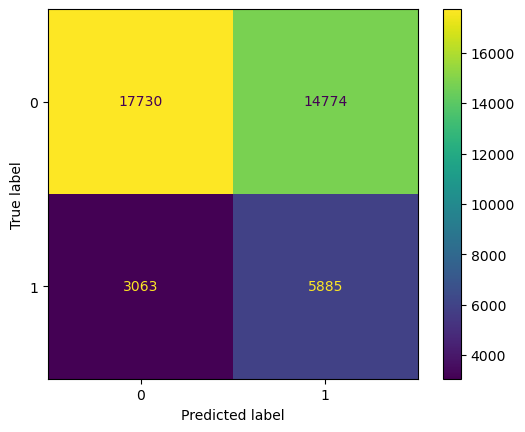

In [32]:
print(classification_report(y_true = y_test, y_pred = pred))
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test);

## Question No.4: If there were no model, what would be the total cost to the banks of dealing with the complaints in the test set?  Pick the closest value to what you get.

From Question No.2, we get:

In [33]:
print(44903*100 + 44903*600)

31432100


Use the predictions for which complaints are likely to be disputed from the model you have created (using the default classification threshold).  Assume that if the model predicts a complaint will be disputed, the banks decide to spend ```$90``` performing extra diligence to avoid the ```$600``` cost of a dispute.

## Question No.5: In this situation based on model results, what would be the total cost to the banks of dealing with the complaints in the test set?

From Question No.3, we get:

In [34]:
print(17730*100 + 5885*190 + 3063*600 + 14774*190)

7536010


The costs to the banks from doing due diligence and from having disputes are asymmetrical.  Therefore you have the opportunity to reduce total cost by varying the probability threshold from the default 0.5 in a binary classification situation as this.

## Question No.6: Change the value of the threshold and determine the lowest total cost to the banks based on the observations in the test set.

In [35]:
pred_prob = model_xgb.predict_proba(X_test).round(3)
pred_prob

array([[0.382, 0.618],
       [0.568, 0.432],
       [0.543, 0.457],
       ...,
       [0.518, 0.482],
       [0.385, 0.615],
       [0.749, 0.251]], dtype=float32)

Confusion Matrix : 
 [[   66 32438]
 [    0  8948]]
Threshold:  0.1
Test accuracy =  0.21745633503811637
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     32504
           1       0.22      1.00      0.36      8948

    accuracy                           0.22     41452
   macro avg       0.61      0.50      0.18     41452
weighted avg       0.83      0.22      0.08     41452

Total cost:  7869940
Confusion Matrix : 
 [[17730 14774]
 [ 3063  5885]]
Threshold:  0.5
Test accuracy =  0.5696950689954646
              precision    recall  f1-score   support

           0       0.85      0.55      0.67     32504
           1       0.28      0.66      0.40      8948

    accuracy                           0.57     41452
   macro avg       0.57      0.60      0.53     41452
weighted avg       0.73      0.57      0.61     41452

Total cost:  7536010
Confusion Matrix : 
 [[22635  9869]
 [ 4536  4412]]
Threshold:  0.54
Test accuracy =  0.6524896

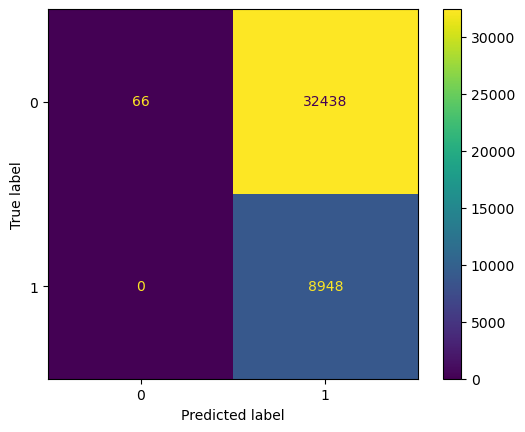

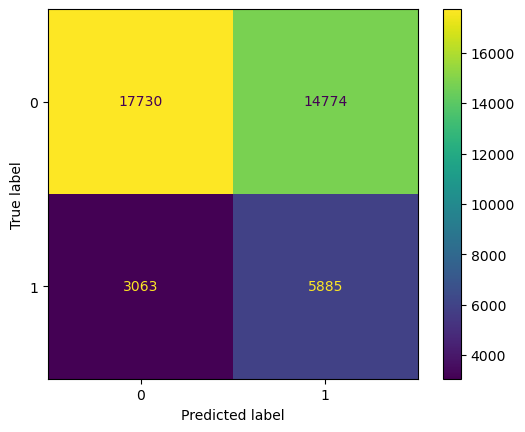

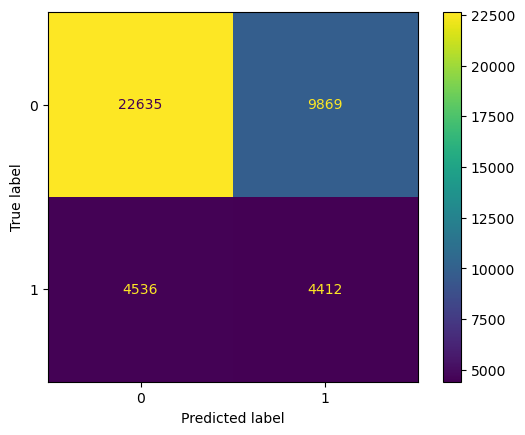

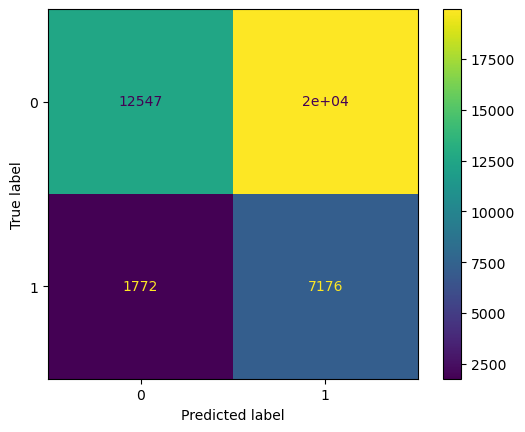

In [36]:
# Set threshold for identifying class 1
threshold = [0.1, 0.50, 0.54, 0.46]

# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

for _ in threshold:
    # Convert probabilities to 1s and 0s based on threshold
    pred = (pred_prob>_).astype(int)
    
    # confusion matrix
    cm = confusion_matrix(y_test, pred)
    print ("Confusion Matrix : \n", cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    print('Threshold: ', _)
    
    # accuracy score of the model
    print('Test accuracy = ', accuracy_score(y_test, pred))
    print(classification_report(y_true = y_test, y_pred = pred,))


    print('Total cost: ', cm[0][0]*100 + cm[0][1]*190 + cm[1][0]*600 + cm[1][1]*190)

## Question No.7: At what value of the threshold is the lowest dollar cost achieved?

From question No.6 we can determine the threshold value which gives the lowest cost.

## Conclusion:
From the analysis done in this notebook it can we clearly identified that in order to minimize the cost of complaint, the True 'No dispute' should be high and the False 'No Dispute' should be low, with other 2 categories varying.

| Created By | Contact |
|------------|---------|
|Sai Deepak Reddy Kothi|deepak.reddy0106@gmail.com|